In [ ]:
# !pip install antspyx --quiet

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import ants
import nibabel as nib
import antspynet

In [3]:
root_dir = "C:/Users/Kumar/OneDrive/Desktop/Brain Spy/ADNI1_Complete 1Yr 1.5T"
nii_files = {}

def import_files(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".nii"):
                nii_files[os.path.basename(root)] = os.path.join(root, file)
                
    print(f"Found {len(nii_files)} NIfTI files")
    return nii_files

import_files(root_dir)

for key, value in list(nii_files.items())[:5]:
    print(f"{key}: {value}")

Found 448 NIfTI files
I40966: C:/Users/Kumar/OneDrive/Desktop/Brain Spy/ADNI1_Complete 1Yr 1.5T\ADNI\002_S_0295\MPR__GradWarp__B1_Correction__N3__Scaled\2006-11-02_08_16_44.0\I40966\ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070219173850420_S21856_I40966.nii
I60008: C:/Users/Kumar/OneDrive/Desktop/Brain Spy/ADNI1_Complete 1Yr 1.5T\ADNI\002_S_0413\MPR__GradWarp__B1_Correction__N3__Scaled\2007-06-01_07_04_09.0\I60008\ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070713121420365_S32938_I60008.nii
I118695: C:/Users/Kumar/OneDrive/Desktop/Brain Spy/ADNI1_Complete 1Yr 1.5T\ADNI\002_S_0413\MPR__GradWarp__B1_Correction__N3__Scaled_2\2006-11-15_09_30_01.0\I118695\ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001120813046_S22557_I118695.nii
I60451: C:/Users/Kumar/OneDrive/Desktop/Brain Spy/ADNI1_Complete 1Yr 1.5T\ADNI\002_S_0619\MPR__GradWarp__N3__Scaled\2006-12-13_08_57_02.0\I60451\ADNI_002_S_0619_MR_MPR__GradWarp__N3__Scaled_Br_2

In [4]:
_, file = list(nii_files.items())[0]
ants_img = ants.image_read(file)
print(ants_img)

ANTsImage (SAR)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 166)
	 Spacing    : (0.9474, 0.943, 1.2016)
	 Origin     : (-97.0974, -152.507, 142.361)
	 Direction  : [-0.  0.  1.  0.  1. -0. -1.  0.  0.]



In [ ]:
# !pip install tensorflow==2.11.02 --upgrade --quiet
# !pip install antspynet --quiet
# import antspynet

ERROR: Could not find a version that satisfies the requirement tensorflow==2.11.02 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.11.02


5683832/5683832 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
14969865/14969865 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


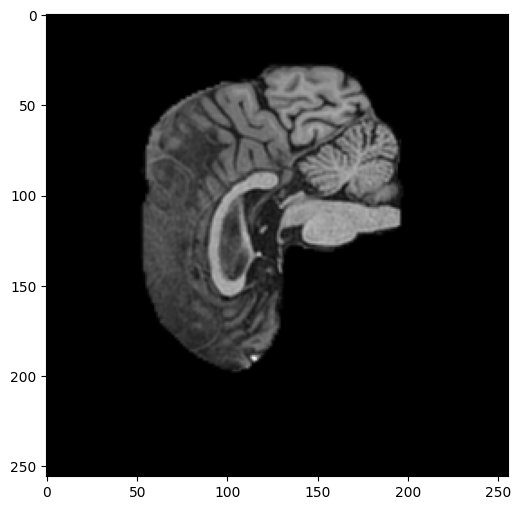

In [7]:
brain = antspynet.brain_extraction(ants_img, modality="t1")
brain_img = (ants_img * brain)
brain_img_data = brain_img.numpy()

plt.figure(figsize=(8,6))
plt.imshow(np.rot90(brain_img_data[:, :, brain_img_data.shape[2]//2]), cmap='gray')
plt.show()

(256, 256, 166)


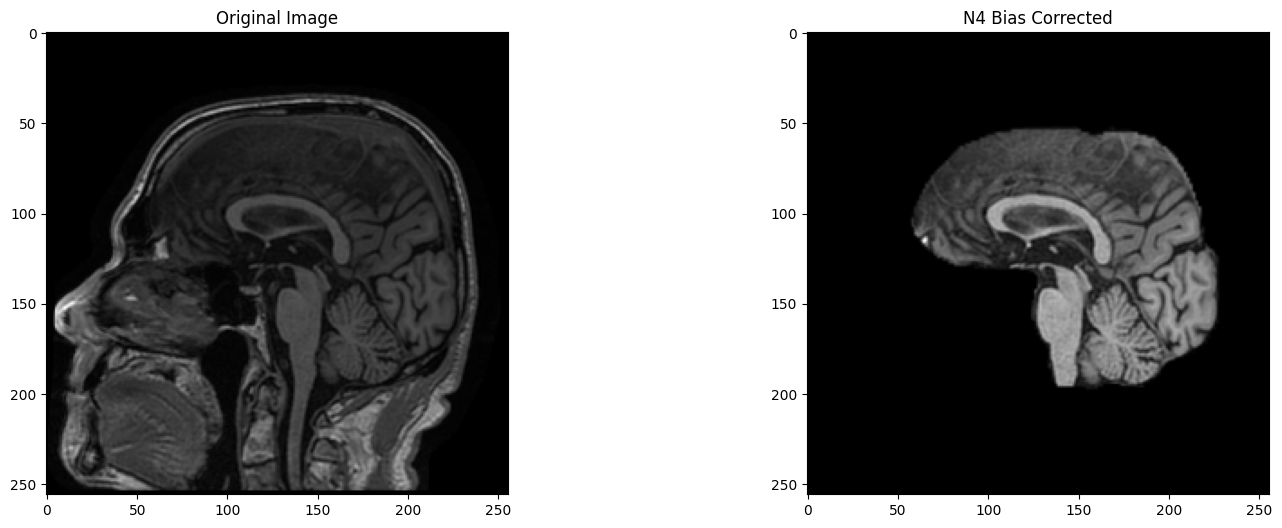

In [8]:
corrected_ants = ants.n4_bias_field_correction(brain_img)
corrected_nii_data = corrected_ants.numpy()

nii_data = nib.load(file).get_fdata()
print (nii_data.shape)

plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.imshow(nii_data[:, :, nii_data.shape[2]//2], cmap = 'gray')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(corrected_nii_data[:, :, corrected_nii_data.shape[2]//2], cmap = 'gray')
plt.title("N4 Bias Corrected")
plt.show()

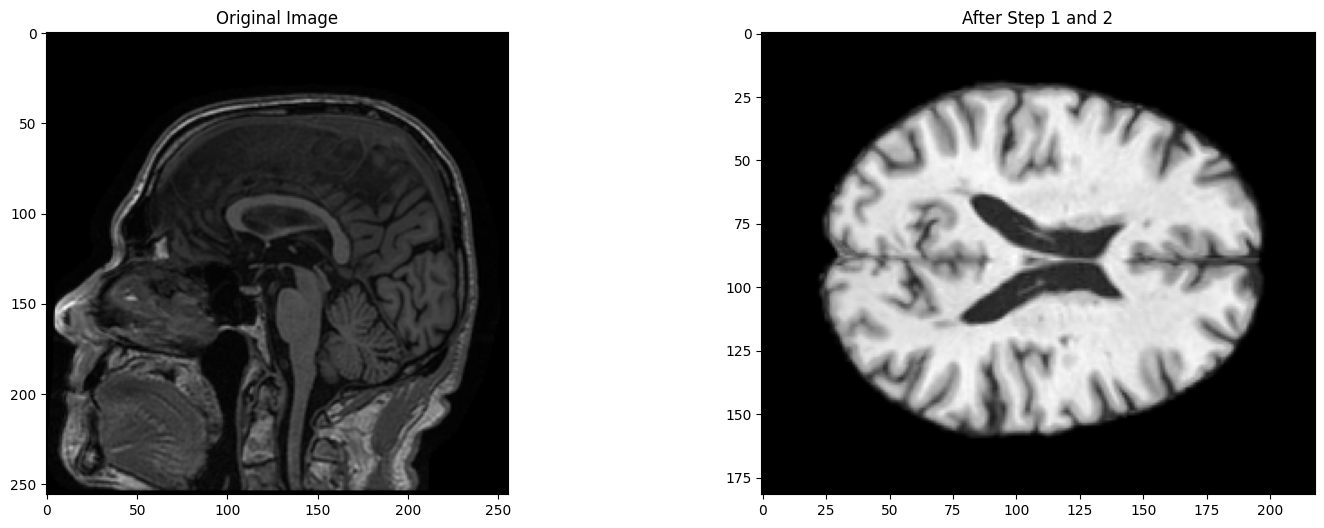

In [9]:
mni = ants.image_read(ants.get_ants_data("mni"))
aligned = ants.registration(fixed=mni, moving=corrected_ants, type_of_transform='SyN')['warpedmovout'].numpy()

plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.imshow(nii_data[:, :, nii_data.shape[2]//2], cmap = 'gray')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(aligned[:, :, aligned.shape[2]//2], cmap = 'gray')
plt.title("After Step 1 and 2")
plt.show()

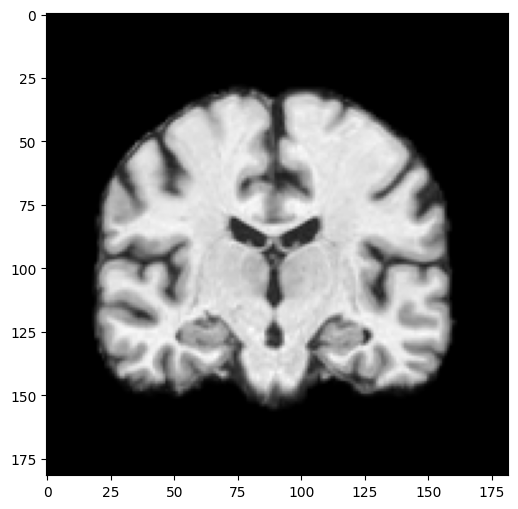

(182, 218, 182)


In [10]:
plt.figure(figsize=(18,6))
plt.imshow(np.rot90(aligned[:,aligned.shape[1]//2,:]), cmap='gray')
plt.show()
print(aligned.shape)

Preprocessing Entire Dataset

In [12]:
output_dir = "ADNI_Preprocessed"
mni = ants.image_read(ants.get_ants_data("mni"))
os.makedirs(output_dir, exist_ok=True)

In [ ]:
for counter, (subject_id, path) in enumerate(nii_files.items(), start = 0):
    try:
        print(f"Processing {counter}: {subject_id}")

        ants_img = ants.image_read(path)

        # Brain extraction
        brain_mask = antspynet.brain_extraction(ants_img, modality="t1")
        brain_img = ants_img * brain_mask

        # Bias correction
        # corrected = ants.n4_bias_field_correction(brain_img)

        # Registration to MNI
        aligned = ants.registration(fixed=mni, moving=brain_img, type_of_transform='SyN')['warpedmovout']

        # Create subject-specific subfolder under ADNI_Preprocessed
        subject_folder = os.path.join(output_dir, subject_id)
        os.makedirs(subject_folder, exist_ok=True)

        # Save NIfTI in .nii.gz format
        save_path = os.path.join(subject_folder, "preprocessed.nii.gz")
        ants.image_write(aligned, save_path)

        print(f"Saved: {save_path}")

    except Exception as e:
        print(f"Failed to process {counter}: {e}")

Processing 0: I40966
Saved: ADNI_Preprocessed\I40966\preprocessed.nii.gz
Processing 1: I60008
Saved: ADNI_Preprocessed\I60008\preprocessed.nii.gz
Processing 2: I118695
Saved: ADNI_Preprocessed\I118695\preprocessed.nii.gz
Processing 3: I60451
Saved: ADNI_Preprocessed\I60451\preprocessed.nii.gz
Processing 4: I40683
Saved: ADNI_Preprocessed\I40683\preprocessed.nii.gz
Processing 5: I118682
Saved: ADNI_Preprocessed\I118682\preprocessed.nii.gz
Processing 6: I73016
Saved: ADNI_Preprocessed\I73016\preprocessed.nii.gz
Processing 7: I40831
Saved: ADNI_Preprocessed\I40831\preprocessed.nii.gz
Processing 8: I64755
Saved: ADNI_Preprocessed\I64755\preprocessed.nii.gz
Processing 9: I62377
Saved: ADNI_Preprocessed\I62377\preprocessed.nii.gz
Processing 10: I64037
Saved: ADNI_Preprocessed\I64037\preprocessed.nii.gz
Processing 11: I109403
Saved: ADNI_Preprocessed\I109403\preprocessed.nii.gz
Processing 12: I73881
Saved: ADNI_Preprocessed\I73881\preprocessed.nii.gz
Processing 13: I81330
Saved: ADNI_Preproce